## Q-Learning for gym's CartPole (using a Neural Network)
[OpenAI gym CartPole](https://gym.openai.com/envs/CartPole-v1/)<br>
This code implements a Neural Network to learn the environment MountainCar. It's a Q-Learning algorithm and not a DQN so it does not count with another network (Q-target) and no Experience Replay.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import gym
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.tensorboard import SummaryWriter

Number of possible actions: 2
Number of possible states: Box(4,)


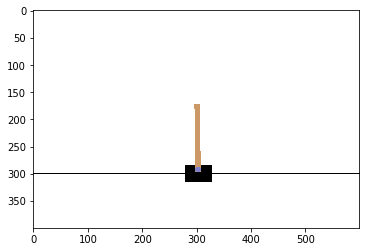

In [2]:
"""
Cart-pole environment.
https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 
The pendulum starts upright, and the goal is to prevent it from falling over by increasing and 
reducing the cart's velocity.

Observation: 
    Type: Box(4)
    Num	Observation                 Min         Max
    0	Cart Position             -4.8            4.8
    1	Cart Velocity             -Inf            Inf
    2	Pole Angle                 -24 deg        24 deg
    3	Pole Velocity At Tip      -Inf            Inf

Actions:
    Type: Discrete(2)
    Num	Action
    0	Push cart to the left
    1	Push cart to the right
""" 


env = gym.make("CartPole-v0").env

print("Number of possible actions:", env.action_space.n)
print("Number of possible states:", env.observation_space)

env.reset()
plt.imshow(env.render("rgb_array"))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
class qAgent:
    def __init__(self, n_action_space, n_observation_space, epsilon, alpha, discount_factor):
        self.n_action_space = n_action_space
        self.n_observation_space = n_observation_space
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.discount_factor = discount_factor
        
        self.qnetwork = nn.Sequential(
                    nn.Linear(n_observation_space[0], 128),
                    nn.ReLU(),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Linear(64, n_action_space)
        ).to(device)
        
    def get_action_epsilon_greedy(self, state):    
        # the action returned either will be random or the greedy
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_action_space) # return a random action
        else: # else, be greedy
            state = torch.tensor(state, dtype=torch.float32, device=device)
            qvalues = self.qnetwork(state).detach() # returns a new Tensor, detached from the current graph.
            action = torch.argmax(qvalues).item() 
        return action
    
    def get_greedy_action(self, state):
        state = torch.tensor(state, dtype=torch.float32, device=device)
        qvalues = self.qnetwork(state).detach() # returns a new Tensor, detached from the current graph.
        action = torch.argmax(qvalues).item() 
        return action
    
    def get_qvalues(self, state):
        return self.qnetwork(state)
   
    def calculate_loss(self, state, action, new_state, reward, done):
        # convert variables to tensor
        state = torch.tensor(state, dtype=torch.float32, device=device)
        new_state = torch.tensor(new_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device)

        # predict all q-values for current state
        all_qvalues_state = self.get_qvalues(state)
       
        # select the q_value for the agent action
        qvalue_state = all_qvalues_state[action]
        
        # predict all q-values for the new state 
        all_qvalues_new_state = self.get_qvalues(new_state)
       
        # index of action that maximizes the new state q(s,a)
        argmax_new_action = torch.argmax(all_qvalues_new_state)
        # select the q-value for the new state for the action that maximises it, q'(s',amax)
        qvalue_new_state =  all_qvalues_new_state[argmax_new_action]
        
 
        # if it's a terminal state (done) the target it receives only the value of the reward
        if done:
            max_qvalue_new_state = reward
        else:
            max_qvalue_new_state = reward + self.discount_factor*qvalue_new_state

        # loss = MSE (mean squared error) between Q-network and Q-learning targets
        # the detach is a way to fix the network by not having their gradients computed
        loss = F.mse_loss(max_qvalue_new_state.detach(), qvalue_state)
        
        return loss

In [5]:
# hyperparameters
epsilon = 0.5
alpha = 0.5
discount_factor = 0.99

agent = qAgent(n_action_space=env.action_space.n,
               n_observation_space=env.observation_space.shape,
               epsilon=epsilon,
               alpha=alpha,
               discount_factor=discount_factor)


In [6]:
learning_rate = 0.0001
optimiser = torch.optim.Adam(agent.qnetwork.parameters(), lr=learning_rate)

In [7]:
# writter for tensorboard
writer = SummaryWriter()
# to see the board run on terminal the following command:
# tensorboard --logdir=runs

In [8]:
def train(trials_episode=100, solved_reward=200, n_epochs=1000):
    total_reward = []
    
    for epoch in range(n_epochs):
        
        rewards_epoch = []
        for trial in range(trials_episode):
            state = env.reset()
            done = False
            ep_rewards = 0.0
            while not done:
                action = agent.get_action_epsilon_greedy(state)

                new_state, reward, done, info = env.step(action)

                optimiser.zero_grad()
                loss = agent.calculate_loss(state, action, new_state, reward, done)
                loss.backward()
                optimiser.step()

                state = new_state
                ep_rewards += reward

            rewards_epoch.append(ep_rewards)
            total_reward.append(ep_rewards)
            writer.add_scalar('Reward/Train', ep_rewards, epoch*trials_episode+trial)
        
        print("Epoch={} \t epsilon={:.2f}\t reward(mean)={:.2f}".format(epoch+1, agent.epsilon, np.mean(rewards_epoch)))    
        agent.epsilon *= 0.95
        if np.mean(rewards_epoch) > solved_reward:
            break
            
    return total_reward

Epoch=1 	 epsilon=0.50	 reward(mean)=14.51
Epoch=2 	 epsilon=0.47	 reward(mean)=13.76
Epoch=3 	 epsilon=0.45	 reward(mean)=14.72
Epoch=4 	 epsilon=0.43	 reward(mean)=12.49
Epoch=5 	 epsilon=0.41	 reward(mean)=13.84
Epoch=6 	 epsilon=0.39	 reward(mean)=12.78
Epoch=7 	 epsilon=0.37	 reward(mean)=21.09
Epoch=8 	 epsilon=0.35	 reward(mean)=27.07
Epoch=9 	 epsilon=0.33	 reward(mean)=40.70
Epoch=10 	 epsilon=0.32	 reward(mean)=42.29
Epoch=11 	 epsilon=0.30	 reward(mean)=47.04
Epoch=12 	 epsilon=0.28	 reward(mean)=47.20
Epoch=13 	 epsilon=0.27	 reward(mean)=61.65
Epoch=14 	 epsilon=0.26	 reward(mean)=73.67
Epoch=15 	 epsilon=0.24	 reward(mean)=119.12
Epoch=16 	 epsilon=0.23	 reward(mean)=157.38
Epoch=17 	 epsilon=0.22	 reward(mean)=160.28
Epoch=18 	 epsilon=0.21	 reward(mean)=154.53
Epoch=19 	 epsilon=0.20	 reward(mean)=205.30


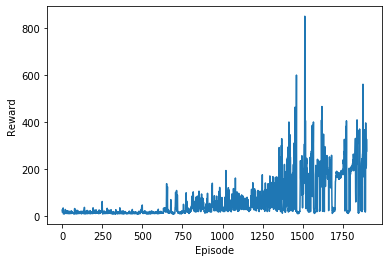

In [9]:
# CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials.
# https://github.com/openai/gym/wiki/Leaderboard

rewards = train(trials_episode=100, solved_reward=200, n_epochs=2000)

plt.plot(rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [10]:
# play some episodes to see how it's working 
from time import sleep

def validation_test(env, n_episodes=3):
    agent.qnetwork.eval() # set model to evaluation mode
    with torch.no_grad():
        for i in range(n_episodes):
            state = env.reset()
            done = False
            reward_sum = 0
            while not done:
                env.render()
                #state = torch.tensor(state, dtype=torch.float32, device=device)
                action = agent.get_greedy_action(state)

                state, reward, done, _ = env.step(action)
                reward_sum += reward

                sleep(0.01)
            print("Episode finished. Reward={:.4f}".format(reward_sum))

validation_test(env)

Episode finished. Reward=316.0000
Episode finished. Reward=325.0000
Episode finished. Reward=365.0000


In [11]:
torch.save(agent.qnetwork.state_dict(), "./agents/Q-Learning-CartPole.pt")

In [12]:
# play some games with the trained agent
from gym import wrappers
dir_videos = "./qlearning-results-cartpole"

env_monitor = wrappers.Monitor(env, directory=dir_videos, force=True)

for _ in range(10):
    validation_test(env_monitor, n_episodes=3)
env_monitor.close()

Episode finished. Reward=428.0000
Episode finished. Reward=331.0000
Episode finished. Reward=310.0000
Episode finished. Reward=709.0000
Episode finished. Reward=303.0000
Episode finished. Reward=834.0000
Episode finished. Reward=456.0000
Episode finished. Reward=344.0000
Episode finished. Reward=436.0000
Episode finished. Reward=314.0000
Episode finished. Reward=307.0000
Episode finished. Reward=264.0000
Episode finished. Reward=301.0000
Episode finished. Reward=421.0000
Episode finished. Reward=351.0000
Episode finished. Reward=367.0000
Episode finished. Reward=348.0000
Episode finished. Reward=352.0000
Episode finished. Reward=333.0000
Episode finished. Reward=321.0000
Episode finished. Reward=341.0000
Episode finished. Reward=344.0000
Episode finished. Reward=390.0000
Episode finished. Reward=277.0000
Episode finished. Reward=313.0000
Episode finished. Reward=418.0000
Episode finished. Reward=320.0000
Episode finished. Reward=380.0000
Episode finished. Reward=249.0000
Episode finish